# Visualization ConvNet Filters by Activation Maximization

In [1]:
import torch
from torch import nn
import timm
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

e:\Rijan_Shrestha\AI\AI Works\Paper-Reproduction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Filter visualization using Gradient Ascent

### Plan:
1. Initialize the pretrained model - Xception using timm (not available in torchvision)
2. To extract the output of the certain layer, create the hook and register it for forward pass
3. Initialize the empty tensor of shape 1, 224, 224 for creating blank image
4. With the layer as the features extractor, forward pass the blank image and take the score of that as the loss we need
5. Backward pass on the loss
6. Keeping the weights and bias constant, take the optimizer to update the value of the pixel for maximal activation
7. Visualize the generated image

In [93]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [94]:
model = timm.create_model('xception', pretrained = True, global_pool = '', num_classes = 0)
model = model.to(device).eval()
summary(model, (3, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 89, 89]             864
       BatchNorm2d-2           [-1, 32, 89, 89]              64
              ReLU-3           [-1, 32, 89, 89]               0
            Conv2d-4           [-1, 64, 87, 87]          18,432
       BatchNorm2d-5           [-1, 64, 87, 87]             128
              ReLU-6           [-1, 64, 87, 87]               0
            Conv2d-7           [-1, 64, 87, 87]             576
            Conv2d-8          [-1, 128, 87, 87]           8,192
   SeparableConv2d-9          [-1, 128, 87, 87]               0
      BatchNorm2d-10          [-1, 128, 87, 87]             256
             ReLU-11          [-1, 128, 87, 87]               0
           Conv2d-12          [-1, 128, 87, 87]           1,152
           Conv2d-13          [-1, 128, 87, 87]          16,384
  SeparableConv2d-14          [-1, 128,

In [121]:
layers = dict(model.named_modules())
layers.keys()

dict_keys(['', 'conv1', 'bn1', 'act1', 'conv2', 'bn2', 'act2', 'block1', 'block1.skip', 'block1.skipbn', 'block1.rep', 'block1.rep.0', 'block1.rep.0.conv1', 'block1.rep.0.pointwise', 'block1.rep.1', 'block1.rep.2', 'block1.rep.3', 'block1.rep.3.conv1', 'block1.rep.3.pointwise', 'block1.rep.4', 'block1.rep.5', 'block2', 'block2.skip', 'block2.skipbn', 'block2.rep', 'block2.rep.0', 'block2.rep.1', 'block2.rep.1.conv1', 'block2.rep.1.pointwise', 'block2.rep.2', 'block2.rep.3', 'block2.rep.4', 'block2.rep.4.conv1', 'block2.rep.4.pointwise', 'block2.rep.5', 'block2.rep.6', 'block3', 'block3.skip', 'block3.skipbn', 'block3.rep', 'block3.rep.0', 'block3.rep.1', 'block3.rep.1.conv1', 'block3.rep.1.pointwise', 'block3.rep.2', 'block3.rep.3', 'block3.rep.4', 'block3.rep.4.conv1', 'block3.rep.4.pointwise', 'block3.rep.5', 'block3.rep.6', 'block4', 'block4.rep', 'block4.rep.0', 'block4.rep.1', 'block4.rep.1.conv1', 'block4.rep.1.pointwise', 'block4.rep.2', 'block4.rep.3', 'block4.rep.4', 'block4.r

In [140]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

layer_name = "block8.rep.4.conv1"
layer = dict(model.named_modules())[layer_name]

# Register the hook
handle = layer.register_forward_hook(get_activation(layer_name))

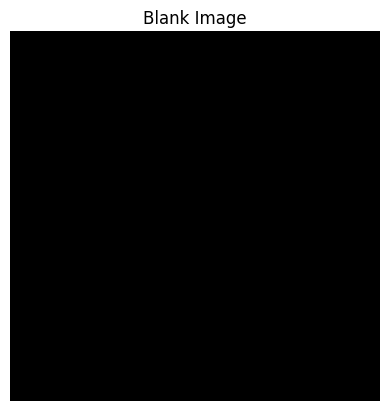

In [123]:
#Crete the blank image
blank_image = torch.zeros(1 , 3, 180, 180, device = device, requires_grad= True)

plt.imshow(blank_image.detach().cpu().permute(0, 2, 3, 1).squeeze(0))
plt.title("Blank Image")
plt.axis('off')
plt.show()

In [141]:
# Forward pass
def feature_extractor(x):
    model(x)
    return activation["block8.rep.4.conv1"]

In [127]:
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    feature = activation[:, filter_index, 2:-2, 2:-2]
    return torch.mean(feature)

compute_loss(blank_image, 3)

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)

In [128]:
def gradient_ascent_step(image, filter_index, learning_rate = 10.0):
    image = image.clone().detach().requires_grad_(True)

    loss = compute_loss(image, filter_index)
    loss.backward()

    grads = image.grad
    grads_norm = torch.norm(grads, p = 2) + 1e-8
    normalized_grads = grads / grads_norm
    image = image + learning_rate * normalized_grads

    return image.detach()
    

In [129]:
def generate_filter_pattern(filter_index, img_size = 299, iterations = 30, lr = 10.0):
    image = torch.randn(1, 3, img_size, img_size, device = device) * 0.2 - 0.1
    image = image.requires_grad_(True)

    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, lr)

    return image.squeeze(0).detach()

In [130]:
def deprocess_image(img_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()

    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    img+= 0.5
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

In [151]:
filter_index = 1

generated_image = generate_filter_pattern(filter_index)
final_image = deprocess_image(generated_image)
final_image.shape

(299, 299, 3)

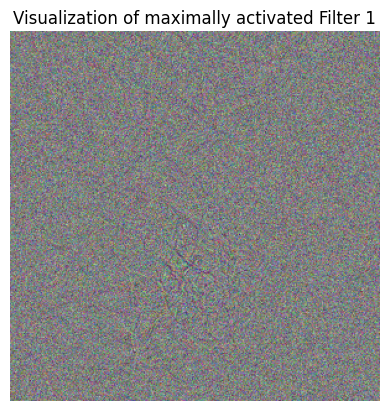

In [143]:
plt.imshow(final_image, cmap='viridis')
plt.axis('off')
plt.title(f"Visualization of maximally activated Filter {filter_index}")
plt.show()

In [ ]:
all_images = []  # 1
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(generate_filter_pattern(filter_index))
    all_images.append(image)

margin = 5  # 2
n = 8
img_height, img_width, channels = all_images[0].shape

box_height = img_height - 25 * 2
box_width = img_width - 25 * 2

full_height = n * box_height + (n - 1) * margin
full_width = n * box_width + (n - 1) * margin

stitched_filters = np.zeros((int(full_height), int(full_width), 3), dtype=np.uint8)

for i in range(n):
    for j in range(n):
        img = all_images[i * n + j]

        y_start = i * (box_height + margin)
        y_end = y_start + box_height
        x_start = j * (box_width + margin)
        x_end = x_start + box_width

        stitched_filters[int(y_start) : int(y_end), int(x_start) : int(x_end), :] = (
            img_cropped
        )

plt.figure(figsize=(12, 12))
plt.imshow(stitched_filters)
plt.axis("off")
plt.title(f"Filters for layer {layer_name}")
plt.show()

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
